<center><b><font size="5">H(750) decays to gauge boson pairs</font></b></center>

## Intro and definitions

### Packages and constants

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import math
from sympy import *
from scipy.optimize import root, brentq
from sympy.abc import tau, sigma, x, D, T, Q, Y, N
T3, sigmaprime = symbols('T3, sigmaprime')

In [2]:
# local packages
from plothelp import label_line
import smgroup
from constants import *
smgroup.GUTU1 = False  # we don't work here with GUT-unified value for alpha_1

### One-loop decays to pairs of gauge bosons

#### Factors different for different VV channels

In [3]:
def VVfact(S1, S2, S3):
    """Factors for loop decays to VV channels.
    Phase space factors for identical particles accounted for here.
    
    """
    gg = S1 + S2
    GG = (2*S3)*(alphas/alpha)*sqrt(Kfactor)
    ZZ = (cw2/sw2)*S2 + (sw2/cw2)*S1
    Zg = sqrt(2)*( (cw/sw)*S2 - (sw/cw)*S1 )
    WW = sqrt(2) * S2 / sw2
    return {'gg':gg, 'GG':GG, 'ZZ':ZZ, 'Zg':Zg, 'WW':WW}


def VVfactW(D=7, Y=0, real=True, wght=False):
    """Factors for loop decays to VV channels.
    Phase space factors for identical particles accounted for here.
    
    wght --- T3-weight factor entering sum over multiplet
    
    """
    r, wNC, wCC = (1, 1, 1)
    if real:
        r = 2
    if wght:
        # Weights for CKP model quintuplet scalars which don't
        # couple universally to H
        wNC = (2-T3)/4
        wCC = (3-2*T3)/8  # average of (2-T3)/4 and (1-T3)/4
    T = (D-S(1))/2  # weak isospin
    gg = summation((wNC*Q**2).subs(Q,T3+Y/2).evalf(), (T3, -T, T))/r
    GG = 0
    ZZ = summation((wNC*(T3-sw2*Q)**2).subs(Q,T3+Y/2).evalf(), (T3, -T, T))/sw2/cw2/r
    Zg = sqrt(2)*summation((wNC*Q*(T3-sw2*Q)).subs(Q,T3+Y/2).evalf(), (T3, -T, T))/sw/cw/r
    WW = sqrt(2) * summation((wCC*(T-T3)*(T+T3+1)/2).evalf(), (T3, -T, T))/sw2/r
    return {'gg':gg, 'GG':GG, 'ZZ':ZZ, 'Zg':Zg, 'WW':WW}

In [4]:
def Rtogg(reps, prt=False):
    """Ratios of VV to gamma-gamma channels."""
    VVs = VVfact(*smgroup.SMDynkin(reps))
    gg = VVs['gg']
    RGG = float((VVs['GG']/gg)**2)
    RZg = float((VVs['Zg']/gg)**2)
    RZZ = float((VVs['ZZ']/gg)**2)
    RWW = float((VVs['WW']/gg)**2)
    if prt:
        print("RGG = {:.3f}, RZg = {:.3f},  RZZ = {:.3f},   RWW  = {:.3f}".format(RGG,
            RZg, RZZ , RWW)  )
    return RGG, RZg, RZZ, RWW
    
def RtoggW(D=7, Y=0, real=True, wght=False, prt=False):
    """Ratios of VV to gamma-gamma channels if T3-weights are needed."""
    VVs = VVfactW(D, Y, real, wght)
    gg = VVs['gg']
    RGG = float((VVs['GG']/gg)**2)
    RZg = float((VVs['Zg']/gg)**2)
    RZZ = float((VVs['ZZ']/gg)**2)
    RWW = float((VVs['WW']/gg)**2)
    if prt:
        print("RGG = {:.3f}, RZg = {:.3f},  RZZ = {:.3f},   RWW  = {:.3f}".format(RGG,
            RZg, RZZ , RWW)  )
    return RGG, RZg, RZZ, RWW

In [5]:
# Check of consistency of two formulas
res = Rtogg([smgroup.RealScalar(1,7,0)], prt=True)
res = RtoggW(D=7, Y=0, real=True, prt=True)

RGG = 0.000, RZg = 6.547,  RZZ = 10.716,   RWW  = 36.526
RGG = 0.000, RZg = 6.547,  RZZ = 10.716,   RWW  = 36.526


In [6]:
res = Rtogg([smgroup.ComplexScalar(1,5,-1)], prt=True)
res = RtoggW(D=5, Y=-1, real=False, prt=True)

RGG = 0.000, RZg = 4.785,  RZZ = 8.666,   RWW  = 28.860
RGG = 0.000, RZg = 4.785,  RZZ = 8.666,   RWW  = 28.860


Note that first set is consistent with table  below Fig. 4 of Strumia's [arXiv:1605.09401](http://www.arXiv.org/pdf/1605.09401), which has RZg=7, RZZ=12, RWW=40. We can reproduce second row of his table with some SU(2) singlet:

In [7]:
res = Rtogg([smgroup.ComplexScalar(1,1,-1)], prt=True)
res = RtoggW(D=1, Y=-1, real=False, prt=True)

RGG = 0.000, RZg = 0.611,  RZZ = 0.093,   RWW  = 0.000
RGG = 0.000, RZg = 0.611,  RZZ = 0.093,   RWW  = 0.000


#### Final expression for $H\to VV$ width

$$\Gamma(h\to\gamma\gamma) = B \left|\sum_i Q_i^2 A_{i}(\tau_i) \right|^2$$
$$ B = \frac{\alpha^2 g^2 m_h^3}{1024 \pi^3 m_W^2} = \frac{G_F \alpha^2 m_h^3}{
128\sqrt{2} \pi^3}$$
$$\tau_i = \frac{4m_i^2}{m_{H}^2} $$
$$A_{0}(\tau) = -\tau(1-\tau f(\tau)) \to \frac{1}{3}  \quad \text{for} \quad \tau\to\infty$$
$$A_{1/2}(\tau) = 2\tau\big(1+(1-\tau)f(\tau)\big) = 2 + (4 m^2 -m_{H}^2)C_0(0,0,m_{H}^2,m^2,m^2,m^2)$$
$$f(\tau) = \arcsin^2(\sqrt{\frac{1}{\tau}})  \quad \text{for} \quad \tau\ge 1$$
$$f(\tau) = -\frac{m_H^2}{2} C_0 (0,0,m_H^2; m, m, m) $$

In [8]:
# Loop functions

def f(tau):
    return asin(1/sqrt(tau))**2

def A0(tau):
    return -tau*(1-tau*f(tau))

def A1(tau):
    return -2-3*tau-3*tau*(2-tau)*f(tau)

def A12(tau):
    return 2*tau*(1+(1-tau)*f(tau))

In [9]:
# numpy-approved versions
fN = lambdify(x, f(x), 'numpy')
A0N = lambdify(x, A0(x), 'numpy')
A1N = lambdify(x, A1(x), 'numpy')
A12N = lambdify(x, A12(x), 'numpy')

def tauN(m, mH=750):
    return 4*m**2/mH**2

In [10]:
print(" A0 --> {}".format(limit(A0(tau), tau, oo)))
print("A12 --> {}".format(limit(A12(tau), tau, oo)))
print(" A1 --> {}".format(limit(A1(tau), tau, oo)))

 A0 --> 1/3
A12 --> 4/3
 A1 --> -7


In [11]:
# Numerical check of the relation of C0 and f(tau):
# LoopTools for mH=125, m=375
# fLT = 0.028038859
f(4*375**2/125**2)

0.0280388592343634

SM $h(125)\to\gamma\gamma$ width in GeV (just W and top contributions)

In [12]:
Bh = (GF * alpha**2 * mh**3)/(128 * sqrt(2) * pi**3).evalf()
Bh * (A1N(tauN(mW,mh)) + 3*(2/3)**2*A12N(tauN(mt,mh)))**2

1.00329023145110e-5

This is about right. (2HDMC gives 8.3e-6 GeV). 

Now we define $H\to VV$ decay widths expressions for generic BSM and for ČKP model.

In [13]:
def GAMHVV(VV='gg', 
           BSMfermions=[], BSMscalars=[], gHFF=v, mF=400, gHSS=v, mS=400):
    """Decay width of scalar H to pair of gauge bosons (generic model)"""
    B = float((alpha**2 * mH**3)/(1024 * pi**3).evalf())
    VVf = VVfact(*smgroup.SMDynkin(BSMfermions))[VV]
    VVs = VVfact(*smgroup.SMDynkin(BSMscalars))[VV]
    amp = - (2*gHFF/mF)*VVf*A12N(tauN(mF))
    amp += - (gHSS/mS**2)*VVs*A0N(tauN(mS))
    return B * amp**2

In [14]:
def GAMHckp(VV='gg', tau=1, sig=1, sigpri=1, mchi=400, mphi=400):
    """Decay width of scalar H to pair of gauge bosons (CKP model)"""
    B = float((alpha**2 * mH**3)/(1024 * pi**3).evalf())
    VVtau = VVfactW(D=7, Y=0, real=True)[VV]
    VVsig = VVfactW(D=5, Y=-2, real=False)[VV]
    VVsigpri = VVfactW(D=5, Y=-2, real=False, wght=True)[VV]
    amp = tau*v*VVtau/mchi**2 * A0N(tauN(mchi))
    amp += (sig*v*VVsig/mphi**2 + sigpri*v*VVsigpri/mphi**2) * A0N(tauN(mphi))
    return B * amp**2

In [15]:
GAMHckp('gg'), GAMHckp('WW')

(0.00198329071986041, 0.0353740237419684)

These numbers agree with my older notebook used for initial plots. Another check: CKP model widths with $\sigma'=0$ (i.e. septuplet plus universal quintuplet contributions) can also be calculated with generic function ``GAMHVV``.

In [16]:
[GAMHckp(VV, sigpri=0) for VV in ['gg', 'Zg', 'ZZ', 'WW']]

[0.000968470022007610,
 0.00380749333876153,
 0.00738691723814960,
 0.0242276310052007]

In [17]:
[GAMHVV(VV, BSMscalars=[smgroup.RealScalar(1,7,0), smgroup.ComplexScalar(1,5,-2)], gHSS=v) for VV in ['gg', 'Zg', 'ZZ', 'WW']]

[0.000968470022007610,
 0.00380749333876153,
 0.00738691723814960,
 0.0242276310052007]

## Models

### (For check) Bhupal Dev et al. [1512.08507] [1512.06028](http://arxiv.org/pdf/1512.08507)

In [18]:
bdrep = [smgroup.Dirac(3,1,S(4)/3), smgroup.Dirac(3,1,-S(2)/3), smgroup.Dirac(1,1,-2)]
Rtogg(bdrep)

(184.03211250000004, 0.6109660574412531, 0.09331988083632721, 0.0)

This is in good agreement with their Table 1:
RGG = 220, RZg = 0.61, RZZ = 0.091

Let's also check decay width formula (again in ratios only)

In [19]:
# RGG
GAMHVV('GG', BSMfermions=bdrep, gHFF=246, mF=400)/GAMHVV(BSMfermions=bdrep, gHFF=246, mF=400)

184.032112500000

In [20]:
# RZg
GAMHVV('Zg', BSMfermions=bdrep, gHFF=246, mF=400)/GAMHVV(BSMfermions=bdrep, gHFF=246, mF=400)

0.610966057441253

In [21]:
# RZZ
GAMHVV('ZZ', BSMfermions=bdrep, gHFF=246, mF=400)/GAMHVV(BSMfermions=bdrep, gHFF=246, mF=400)

0.0933198808363272

In [22]:
# RWW
GAMHVV('WW', BSMfermions=bdrep, gHFF=246, mF=400)/GAMHVV(BSMfermions=bdrep, gHFF=246, mF=400)

0

### (For check) Elllis and Ellis et al. [1512.05327](http://arxiv.org/pdf/1512.05327)

In [23]:
# Model 1 
Rtogg([smgroup.Dirac(3,1,S(4)/3), smgroup.Dirac(3,1,-S(4)/3)])

(184.03211250000004, 0.6109660574412531, 0.09331988083632721, 0.0)

In [24]:
# Zg above agrees with Eq. (32) of 1512.07616
2*sw2/cw2

0.6109660574412533

In [25]:
# Model 2 
Rtogg([smgroup.Dirac(3,2,S(1)/3), smgroup.Dirac(3,2,-S(1)/3)])

(471.12220800000006, 4.949186583651335, 8.860755684015464, 29.585798816568047)

In [26]:
# Model 3 
Rtogg([smgroup.Dirac(3,1,S(4)/3), smgroup.Dirac(3,1,-S(4)/3), smgroup.Dirac(3,2,S(1)/3), smgroup.Dirac(3,2,-S(1)/3), smgroup.Dirac(3,1,-S(2)/3), smgroup.Dirac(3,1,S(2)/3)])

(471.12220800000006, 0.5205864631452098, 2.693184885254764, 7.396449704142012)

They have e.g. for the Model 3:
RGG = 460, RZg = 1.1,  RZZ = 2.8,   RWW  = 15.

So, their RZg and RWW look **factor 2 too large**.

### (For check) Benbrik et al. [1512.06028](http://arxiv.org/pdf/1512.06028v3)

In [27]:
# VLTQ model of Benbrik and al.
Rtogg([smgroup.Dirac(3,3,S(4)/3), smgroup.Dirac(3,3,-S(2)/3)])

(40.754516262975784, 2.484579177180838, 5.762673183206281, 18.19964556190268)

Benbrink at al have:
RGG = 40, RZg = 2.29,  RZZ = 5.59,   RWW  = 8.88

So their RWW looks **factor 2 too small**.

### "Our" one-loop  (BPR) model

For the purposes of couplings to H(750) and gauge bosons, we have **one Dirac doublet** (times the number of generations, of course)

In [28]:
bpr = [smgroup.Dirac(1,2,-1)]
smgroup.SMDynkin(bpr)

(1/2, 1/2, 0)

In [29]:
RGGbpr, RZgbpr, RZZbpr, RWWbpr = Rtogg(bpr, prt=True)

RGG = 0.000, RZg = 0.789,  RZZ = 3.202,   RWW  = 9.131


In [30]:
# Branching ratio to gamma gamma:
BrBPRgg = GAMHVV('gg', BSMfermions=bpr)/(GAMHVV('gg', BSMfermions=bpr)+GAMHVV('Zg', BSMfermions=bpr)+GAMHVV('ZZ', BSMfermions=bpr)+GAMHVV('WW', BSMfermions=bpr))
BrBPRgg

0.0708054803374501

In [31]:
# OA's factor 
10.8*(750/45)**2 /(64*pi.evalf()**3)**2 * 1000  # fb

0.761837016574111

### "Our" three-loop (ČKP) model

In [32]:
# Factors relevant for H-->gamma gamma
sigmaprime = symbols('sigmaprime')
print(tau*VVfactW(D=7, Y=0, real=True)['gg'])
print(sigma*VVfactW(D=5, Y=-2, real=False)['gg'])
print(sigmaprime*VVfactW(D=5, Y=-2, real=False, wght=True)['gg'])

14*tau
15.0*sigma
12.5*sigmaprime


In [33]:
# Factors relevant for H--> W+ W-  (with sqrt(2)/sw2 factor extracted)
print((tau*VVfactW(D=7, Y=0, real=True)['WW']*sw2/sqrt(2)).evalf())
print((sigma*VVfactW(D=5, Y=-2, real=False)['WW']*sw2/sqrt(2)).evalf())
print((sigmaprime*VVfactW(D=5, Y=-2, real=False, wght=True)['WW']*sw2/sqrt(2)).evalf())

14.0*tau
10.0*sigma
5.0*sigmaprime


One possible check is the known fact that for Y=0 model ratio of WW to $\gamma\gamma$ decay widths is $2/s_{W}^4=36.5$. We have such model for $\sigma=\sigma'=0$.

In [34]:
GAMHckp('WW', sig=0, sigpri=0)/GAMHckp('gg', sig=0, sigpri=0)

36.5256775513186

In [35]:
# Final ratios to gamma gamma channel for tau=sig=sigpri
GAMHckp('Zg')/GAMHckp('gg'), GAMHckp('ZZ')/GAMHckp('gg'), GAMHckp('WW')/GAMHckp('gg')

(3.07584023022985, 4.93832776839717, 17.8360254438432)

In [36]:
# Width for H(750) --> t tbar
GAMHtt = 3*(1/126.5)*mH*mt**2/(8*sw2*mW**2)*(1-tauN(mt))**(3/2); GAMHtt

30.806647064041254

In [37]:
def GAMTOTckp(tau, sig, sigpri, mchi, mphi):
    """Total width of H(750) in CKP model."""
    WW = GAMHckp('WW', tau, sig, sigpri, mchi, mphi)
    ZZ = GAMHckp('ZZ', tau, sig, sigpri, mchi, mphi)
    Zg = GAMHckp('Zg', tau, sig, sigpri, mchi, mphi)
    gg = GAMHckp('gg', tau, sig, sigpri, mchi, mphi)
    TOT = GAMHtt+WW+ZZ+Zg+gg
    return TOT

In [38]:
def GAMTOTckpD(lam, mS):
    """Total width of H(750) in CKP model with degenerate couplings and mases and Br(gg)."""
    WW = GAMHckp('WW', tau=lam, sig=lam, sigpri=lam, mchi=mS, mphi=mS)
    ZZ = GAMHckp('ZZ', tau=lam, sig=lam, sigpri=lam, mchi=mS, mphi=mS)
    Zg = GAMHckp('Zg', tau=lam, sig=lam, sigpri=lam, mchi=mS, mphi=mS)
    gg = GAMHckp('gg', tau=lam, sig=lam, sigpri=lam, mchi=mS, mphi=mS)
    TOT = GAMHtt+WW+ZZ+Zg+gg
    return TOT, gg/TOT

In [39]:
print( "GAMHTOT = {:.1f} GeV;  Br(H-->gamma gamma) = {:.4}".format(*GAMTOTckpD(8, 375)) )

GAMHTOT = 46.6 GeV;  Br(H-->gamma gamma) = 0.01265


## Experimental constraints

### Generalities

750 GeV diphoton excess:

$$\sigma(pp\to H\to \gamma\gamma)_{\rm CMS} = 4.47 \pm 1.86\;{\rm fb}$$
$$\sigma(pp\to H\to \gamma\gamma)_{\rm ATLAS} = 10.6 \pm 2.9\;{\rm fb}$$

Combination by [Di Chiara et al.](<http://arXiv.org/pdf/1512.04939>):
$$\sigma(pp\to H\to \gamma\gamma)_{\rm LHC} = 6.26 \pm 3.32\; {\rm fb}$$

So one could scan 3-10 fb region.

- Width measured by ATLAS is 45 GeV; CMS prefers narrower.

In [40]:
xs_low = 3  # fb
xs_high = 9 

- 2HDM: for $m_H = 750\;{\rm GeV}$, $A$ and $H^\pm$ are also close to 750 GeV.
- Signal is $10^4$ times stronger than SM-like Higgs, so pure 2HDM is hopeless

Higgs production by **gluon-gluon fusion**: 7 and 8 TeV by  [LHC Higgs xs WG](http://arXiv.org/pdf/1307.1347), and 13 TeV by [gluon luminosity ratios](https://twiki.cern.ch/twiki/bin/view/LHCPhysics/CERNYellowReportPageAt1314TeV2014) (13 TeV/8 TeV) being 2.296 for 125 GeV and 4.693 for 750 GeV.

|          | 7 TeV    |  8 TeV   |  13 TeV
|  ----    | -----    |  ------  | -----
| h(125)   | 15.13 pb |  19.27 pb|  44.2 pb
| h(750)   |  93 fb   |  157 fb  |  737 fb

and we have

$$\sigma_{\gamma\gamma} = 737\,{\rm fb}\; Br(H\to\gamma\gamma)$$

In [41]:
ggF13 = 737. # fb
ggF8 = 157.

For production via **photon fusion** $pp \to \gamma \gamma \to H \to \gamma \gamma$ at 13 TeV, [Harland-Lang et al.](http://arXiv.org/abs/1601.07187) have

$$ \sigma = 4.1\,{\rm pb}\, \left(\frac{\Gamma_H}{45\, {\rm GeV}}\right) {\rm Br}(H\to\gamma\gamma)^2$$

while [Csaki et al.](http://arXiv.org/abs/1601.00638) have

$$ \sigma = 10.8 \,{\rm pb}\, \left(\frac{\Gamma_H}{45\, {\rm GeV}}\right) {\rm Br}(H\to\gamma\gamma)^2$$.

They both include elastic and inelastic contributions, the latter also mixed, and in narrow width approximation. For $\sigma = 3-9\,{\rm fb}$, we get from the second choice
branching ratio 1.7-2.9 %, or $\Gamma(H\to\gamma\gamma) = 0.75-1.3\,{\rm GeV}$.

In [42]:
# Same prefactor in picobarn from  Franceschini et al. Eq. (2)
(45*54)/750/(13000)**2 * GeV2fb / 1000 

7.4650175147929

### one-loop BPR model

In [43]:
## So in pure photon fusion production and pure VV decay scenario, we have for total H(750) width range in GeV
GAMbpr_low, GAMbpr_high = [(siggg/10800)*45/BrBPRgg**2 for siggg in (xs_low, xs_high)]
GAMbpr_low, GAMbpr_high

(2.49330992795410, 7.47992978386231)

In [44]:
# Translating this into H->gamma gamma width in GeV:
GAMbpr_HGG_low, GAMbpr_HGG_high = sqrt((xs_low/10800)*GAMbpr_low*45), sqrt((xs_high/10800)*GAMbpr_high*45)
GAMbpr_HGG_low, GAMbpr_HGG_high

(0.176540007078923, 0.529620021236770)

In [45]:
def lam(msig, GAM):
    """Coupling to get given width H->gamma gamma for given loop fermion mass."""
    ss = ( sqrt(256 * pi**3 * GAM / (alpha**2 * mH**3)) ).evalf()
    return float(msig * ss / A12N(tauN(msig)))

lamN = np.frompyfunc(lam, 2, 1)

In [46]:
# Checking that above inverted formula lambda(sigma) is consistent
# with "master" formula sigma(lambda):
lamN(400, GAMHVV('gg', BSMfermions=bpr, gHFF=42, mF=400))

42.00000000000001

So, minimal possible coupling would be:

In [47]:
lam(375, GAMbpr_HGG_low)

43.70652548562802

So, for $N_E=3$, and $\cos\theta_0\sim 1$ we have $\lambda/(4\pi)$ = 1.1 and we are at the border of perturbativity?

Constraints from 8 TeV VV bounds. First, cross sections for pp->H->VV at 8 TeV if pp->H->gg at 13 TeV is in (3 fb, 9 fb)

In [48]:
#rgg = 1.9  # gain for photon fusion xs going from 8 to 13 TeV in Franceschini et al.
# rgg = 3.9   # value from Fichet et al.1512.05751 
rgg = 3   # average value
# For 3 pb
[(xs_low*RVV)/rgg for RVV in [RWWbpr, RZZbpr, RZgbpr, 1]]

[9.131419387829643, 3.2022875273717673, 0.78949365111245, 1.0]

In [49]:
# And for 9 fb
[(xs_high*RVV)/rgg for RVV in [RWWbpr, RZZbpr, RZgbpr, 1]]

[27.394258163488928, 9.6068625821153, 2.36848095333735, 3.0]

In [50]:
# Bounds on pp->H->VV xs from LHC 8 TeV
sig8 = {'WW' : 40, 'ZZ' : 12, 'Zg' : 11, 'gg' : 1.5}  # in fb, from Franceschini

So we see that strongest bound comes from photon photon final state. This can be relaxed
if one takes larger rgg, advocated by some.

In [51]:
def lambound(VV, msig, reps=bpr):
    """Boundary value of gHFF to violate 8 TeV VV xs constraint"""
    VVs = VVfact(*smgroup.SMDynkin(reps))
    RVV = float((VVs[VV]/VVs['gg'])**2)
    # diphoton 13 TeV xs that would mean boundary VV 8 TeV xs
    gamgg = sig8[VV]*rgg/RVV
    Brgg = BrBPRgg  # FIXME: hardwired BPR
    # H->gamma gamma width that would give above diphoton 13 TeV xs
    GAMgg = gamgg*45/10800/Brgg
    return lamN(msig, GAMgg)

### three-loop ČKP model

With ggF as dominant production mechanism we have

$$ \sigma_{VV}^{8\,{\rm TeV}} = 157\,{\rm fb} \; Br(H\to VV)$$

In [52]:
def sig8CKP(VV, tau, sig, sigpri, mchi, mphi):
    """xs in fb for pp-->H-->VV at 8 TeV in CKP model with degenerate couplings an masses"""
    TOT = GAMTOTckp(tau, sig, sigpri, mchi, mphi)
    BrVV = GAMHckp(VV, tau, sig, sigpri, mchi, mphi)/TOT
    # print('GAMH = {:.1f} GeV, Br(H->{}) = {}'.format(TOT, VV, BrVV))
    return ggF8 * BrVV

In [53]:
def fun(VV, tau, s):
    return sig8CKP(VV, tau=tau, sig=s, sigpri=s, mchi=375, mphi=375) - sig8[VV]

In [54]:
def sigboundCKP(VV, tau, init=6):
    """Boundary value of sig=sig' to violate 8 TeV VV xs constraint"""
    return root(lambda s: fun(VV, tau, s), init).x[0]

In [55]:
[sigboundCKP(VV, 8) for VV in ['WW', 'Zg', 'ZZ', 'gg']]

[9.5500996602504369,
 20.258574027941098,
 10.863836197260508,
 5.9733245667941111]

So it is again photon-photon channel that is most restrictive.

In [56]:
def funm(VV, mchi, s):
    return sig8CKP(VV, tau=10, sig=10, sigpri=10, mchi=mchi, mphi=s) - sig8[VV]

In [57]:
def mboundCKP(VV, mchi, init=390):
    """Boundary value of mphi to violate 8 TeV VV xs constraint"""
    return root(lambda s: funm(VV, mchi, s), init).x[0]

## Plots

In [58]:
SAVEPDFS = True

### [Fig. 1a] Enhancement of $h(125)\to\gamma\gamma$ in one-loop BRP model

Enhancement from the lighter of two charged components of triplet scalar (cf. Eq. (10) from Brdar et al.)

In [59]:
def Rgg(lam=1, m=375):
    """Triplet scalar h(125)->gamma gamma enhancement."""
    SM = A1N(tauN(mW,mh)) + 3*(2/3)**2*A12N(tauN(mt,mh))
    BSM = lam * v**2 * A0N(tauN(m,mh)) / (2 * m**2)
    return (1 + BSM/SM)**2

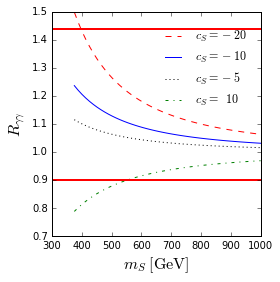

In [60]:
ms = np.linspace(375, 1000)
fig, ax = plt.subplots(figsize=(4,4))
ax.plot(ms, Rgg(lam=-20, m=ms), 'r--', label=r"$c_S=-20$")
ax.plot(ms, Rgg(lam=-10, m=ms), 'b-', label=r"$c_S=-10$")
ax.plot(ms, Rgg(lam=-5, m=ms), 'k:', label=r"$c_S=-5$")
ax.plot(ms, Rgg(lam=10, m=ms), 'g-.', label=r"$c_S=\;\;10$")
#ax.plot(ms, Rgg(lam=20, m=ms), label=r"$c_S=\;\;20$")
ax.set_xlabel(r'$m_S \;{\rm [GeV]}$', fontsize=16)
ax.set_ylabel(r"$R_{\gamma\gamma}$", fontsize=16)
props = dict(color="red", linestyle="-", linewidth=2)
ax.axhline(0.9, **props)
ax.axhline(1.44, **props)
ax.legend(loc=(0.5, 0.55)).draw_frame(0)
plt.tight_layout()
if SAVEPDFS:
    plt.savefig("/home/kkumer/h125gg.pdf")

### [Fig 1b] $H(750)\to\gamma\gamma$ in one-loop BRP model

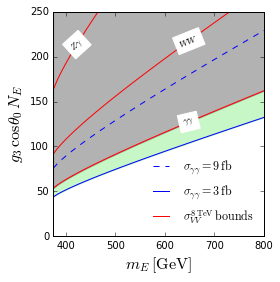

In [61]:
xmin, xmax = 375, 800
ymin, ymax = 0, 250
ms = np.linspace(xmin, xmax)
lam3 = lamN(ms, GAMbpr_HGG_low).astype(np.float)  # 3 fb
lam9 = lamN(ms, GAMbpr_HGG_high).astype(np.float) # 9 fb
# 8 TeV bounds
lamWW = lambound('WW', ms).astype(np.float)
lamZZ = lambound('ZZ', ms).astype(np.float)
lamZg = lambound('Zg', ms).astype(np.float)
lamgg = lambound('gg', ms).astype(np.float)
fig, ax = plt.subplots(figsize=(4,4))
ax.fill_between(ms, lam3, lamgg, color='lightgreen', alpha='0.5')
ax.fill_between(ms, lamgg, ymax, color='gray', alpha='0.6')
ax.plot(ms, lam9, 'b--', label=r'$\sigma_{\gamma\gamma}= 9\,{\rm fb}$')
ax.plot(ms, lam3, 'b-', label=r'$\sigma_{\gamma\gamma}= 3\,{\rm fb}$')
lWW, = ax.plot(ms, lamWW, 'r-', label=r'$\sigma_{VV}^{8\,{\rm TeV}}\,{\rm bounds}$')
lgg, = ax.plot(ms, lamgg, 'r-')
lZg, = ax.plot(ms, lamZg, 'r-')
ax.set_ylabel(r'$g_3\, \cos\theta_0\, N_E$', fontsize=16)
ax.set_xlabel(r'$m_{E}\:{\rm [GeV]}$', fontsize=16)
ax.xaxis.set_major_locator(ticker.MultipleLocator(100))
ax.legend(loc=4).draw_frame(0)
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
plt.tight_layout()
# Put labels on exclusion lines
label_line(lWW, r"$WW$", near_x=650)
label_line(lgg, r"$\gamma\gamma$", near_x=650)
label_line(lZg, r"$Z\gamma$", near_x=420)
if SAVEPDFS:
    plt.savefig("/home/kkumer/triplet.pdf")

### [Fig. 2] Allowed mass/coupling parameter ranges for ČKP model

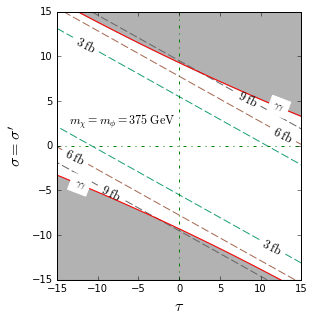

In [62]:
resolution = 60  # of calculation grid 
bmax=15
xs = np.linspace(-bmax, bmax, resolution)
ys = np.linspace(-bmax, bmax, resolution)
levels = [3, 6, 9]
X, Y = np.meshgrid(xs, ys)
#Z = X**2 + Y**2
Z = GAMHckp('gg', tau=X, sig=Y, sigpri=Y, mchi=375, mphi=375)*737./30.
fig, ax = plt.subplots(figsize=(4.5,4.5))
#ax.contour(X, Y, Z, cmap=plt.cm.viridis)
CS = plt.contour(X, Y, Z, levels, cmap=plt.cm.Dark2, linestyles='dashed')
for c in CS.collections:
    c.set_dashes([(0, (8.0, 3.0))])
fig = plt.clabel(CS, inline=1, fmt=r'$%.0f \;{\rm fb}$', fontsize=12, colors='black')
ax.annotate(r'$m_\chi = m_\phi = 375\;{\rm GeV}$', xy=(0.05, 0.58), xycoords='axes fraction', fontsize=12)
ax.set_xlabel(r'$\tau$', fontsize=16)
ax.set_ylabel(r"$\sigma=\sigma'$", fontsize=16)
props = dict(color="green", linestyle="-.", linewidth=1)
ax.axvline(x=0, **props)
ax.axhline(y=0, **props)
cut = 20 # by eyeballing
gs = [sigboundCKP('gg', t, init=-20) for t in xs]
lggL, = plt.plot(xs, gs, 'r-')
ax.fill_between(xs, -bmax, gs, color='gray', alpha='0.6')
gs = [sigboundCKP('gg', t, init=20) for t in xs]
lggH, = plt.plot(xs, gs, 'r-')
ax.fill_between(xs, gs, bmax, color='gray', alpha='0.6')
plt.tight_layout()
fig = plt.ylim(-bmax, bmax)
# Put labels on exclusion lines
label_line(lggL, r"$\gamma\gamma$", near_x=-12)
label_line(lggH, r"$\gamma\gamma$", near_x=12)
if SAVEPDFS:
    plt.savefig("/home/kkumer/tausig.pdf")

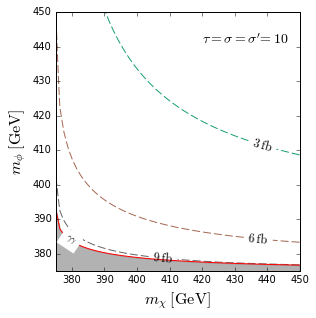

In [63]:
resolution = 60  # of calculation grid 
xs = np.linspace(375, 450, resolution)
ys = np.linspace(375, 450, resolution)
levels = [3, 6, 9]
X, Y = np.meshgrid(xs, ys)
#Z = X**2 + Y**2
Z = GAMHckp('gg', tau=10, sig=10, sigpri=10, mchi=X, mphi=Y)*737./30.
fig, ax = plt.subplots(figsize=(4.5,4.5))
CS = plt.contour(X, Y, Z, levels, cmap=plt.cm.Dark2, linestyles='dashed')
for c in CS.collections:
    c.set_dashes([(0, (8.0, 3.0))])
fig = plt.clabel(CS, inline=1, fmt=r'$%.0f \;{\rm fb}$', fontsize=12, colors='black')
ax.annotate(r"$\tau=\sigma=\sigma' = 10$", xy=(0.6, 0.88), xycoords='axes fraction', fontsize=14)
ax.set_xlabel(r'$m_\chi \; {\rm [GeV]}$', fontsize=16)
ax.set_ylabel(r"$m_\phi \; {\rm [GeV]}$", fontsize=16)
#props = dict(color="green", linestyle="-.", linewidth=1)
#ax.axvline(x=375, **props)
#ax.axhline(y=375, **props)
gs = [mboundCKP('gg', m, init=380) for m in xs]
lgg, = plt.plot(xs, gs, 'r-')
ax.fill_between(xs, 375, gs, color='gray', alpha='0.6')
plt.tight_layout()
# Put labels on exclusion lines
label_line(lgg, r"$\gamma\gamma$", near_x=380)
if SAVEPDFS:
    plt.savefig("/home/kkumer/mm.pdf")

### [Fig 2] $\sigma(pp \to H(750)\to\gamma\gamma)$ in three-loop ČKP model

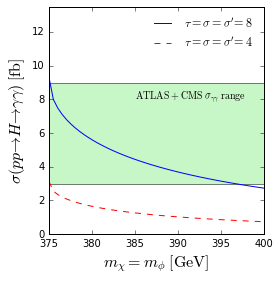

In [64]:
xmin, xmax = 375, 400
ymin, ymax = 0, 13.5
xs = np.linspace(xmin,xmax)
plt.figure(figsize=(4,4))
TOT, BR = GAMTOTckpD(8, xs)
plt.plot(xs , ggF13 * BR, label=r"$\tau=\sigma=\sigma' = 8$")
TOT, BR = GAMTOTckpD(4, xs)
plt.plot(xs , ggF13* BR, 'r--', label=r"$\tau=\sigma=\sigma' = 4$")
plt.ylabel(r'$\sigma(pp\to H\to\gamma\gamma)\;{\rm [fb]}$', fontsize=16)
plt.xlabel(r'$m_{\chi}=m_{\phi}\;{\rm [GeV]}$', fontsize=16)
plt.fill_between(xs, xs_low*np.ones(xs.shape), xs_high*np.ones(xs.shape), facecolor='lightgreen', alpha=0.5)
plt.text(385, 8, r'${\rm ATLAS+CMS}\; \sigma_{\gamma\gamma}\; {\rm range}$')
plt.legend(loc=1).draw_frame(0)
fig = plt.ylim(ymin, ymax)
plt.tight_layout()
if SAVEPDFS:
    plt.savefig('/home/kkumer/diphm.pdf')

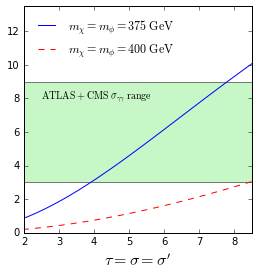

In [65]:
xmin, xmax = 0.2, 12
xs = np.linspace(xmin,xmax)
plt.figure(figsize=(3.7,4))
TOT, BR = GAMTOTckpD(xs, 375)
plt.plot(xs , ggF13*BR, label=r'$m_{\chi} = m_{\phi} = 375 \;{\rm GeV}$')
TOT, BR = GAMTOTckpD(xs, 400)
plt.plot(xs , ggF13*BR, 'r--', label=r'$m_{\chi} = m_{\phi} = 400 \;{\rm GeV}$')
#plt.ylabel(r'$\sigma(pp\to H\to\gamma\gamma)\;{\rm [fb]}$', fontsize=16)
plt.xlabel(r"$\tau=\sigma=\sigma'$", fontsize=16)
plt.fill_between(xs, xs_low*np.ones(xs.shape), xs_high*np.ones(xs.shape), facecolor='lightgreen', alpha=0.5)
plt.text(2.5, 8, r'${\rm ATLAS+CMS}\; \sigma_{\gamma\gamma}\; {\rm range}$')
plt.legend(loc=2).draw_frame(0)
plt.xlim(2, 8.5)
fig = plt.ylim(ymin, ymax)
plt.tight_layout()
if SAVEPDFS:
    plt.savefig('/home/kkumer/diphlam.pdf')

### [Fig 3] $\Gamma_{H(750)}$ in three-loop ČKP model

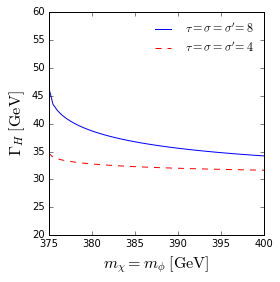

In [66]:
xmin, xmax = 375, 400
ymin, ymax = 20, 60
xs = np.linspace(xmin,xmax)
plt.figure(figsize=(4,4))
TOT, BR = GAMTOTckpD(8, xs)
plt.plot(xs , TOT, label=r"$\tau=\sigma=\sigma' = 8$")
TOT, BR = GAMTOTckpD(4, xs)
plt.plot(xs , TOT, 'r--', label=r"$\tau=\sigma=\sigma' = 4$")
plt.ylabel(r'$\Gamma_H\;{\rm [GeV]}$', fontsize=16)
plt.xlabel(r'$m_{\chi}=m_{\phi}\;{\rm [GeV]}$', fontsize=16)
#plt.fill_between(xs, xs_low*np.ones(xs.shape), xs_high*np.ones(xs.shape), facecolor='lightgreen', alpha=0.5)
#plt.text(388, 8, r'${\rm ATLAS+CMS}\; \gamma\gamma\; {\rm range}$')
plt.legend(loc=1).draw_frame(0)
fig = plt.ylim(ymin, ymax)
plt.tight_layout()
if SAVEPDFS:
    plt.savefig('/home/kkumer/diphGAMm.pdf')

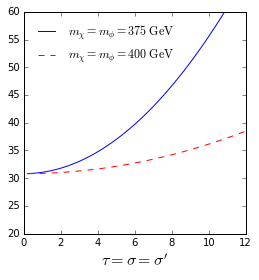

In [67]:
xmin, xmax = 0.2, 12
xs = np.linspace(xmin,xmax)
plt.figure(figsize=(3.7,4))
TOT, BR = GAMTOTckpD(xs, 375)
plt.plot(xs , TOT, label=r'$m_{\chi} = m_{\phi} = 375 \;{\rm GeV}$')
TOT, BR = GAMTOTckpD(xs, 400)
plt.plot(xs , TOT, 'r--', label=r'$m_{\chi} = m_{\phi} = 400 \;{\rm GeV}$')
#plt.ylabel(r'$\sigma(pp\to H\to\gamma\gamma)\;{\rm [fb]}$', fontsize=16)
plt.xlabel(r"$\tau=\sigma=\sigma'$", fontsize=16)
#plt.fill_between(xs, xs_low*np.ones(xs.shape), xs_high*np.ones(xs.shape), facecolor='lightgreen', alpha=0.5)
#plt.text(2.5, 8, r'${\rm ATLAS+CMS}\; \gamma\gamma\; {\rm range}$')
plt.legend(loc=2).draw_frame(0)
#plt.xlim(xmin, xmax)
fig = plt.ylim(ymin, ymax)
plt.tight_layout()
if SAVEPDFS:
    plt.savefig('/home/kkumer/diphGAMlam.pdf')